[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/tobyrmanders/statistical-rethinking/blob/main/code/chapter_04.ipynb)

In [11]:
import torch
from torch import tensor
import torch.distributions.constraints as constraints

import pyro
from pyro import distributions as dist
from pyro.infer.autoguide import AutoLaplaceApproximation
from pyro.infer import svi, Predictive
from pyro import optim
import pyro.ops.stats as stats


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from rethinking import MAP, coef, extract_samples, link, precis, sim, vcov

# 4E1

yi ∼ Normal(µ, σ) 

# 4E2

2

# 4E3

$
P(\mu, \sigma|y) = \frac{\prod_i \text{Normal}(y_i|\mu,\sigma) \text{Normal}(\mu|0,10) \text{Exponential}(\sigma|1)}{\int\int\prod_i \text{Normal}(y_i|\mu,\sigma) \text{Normal}(\mu|0,10) \text{Exponential}(\sigma|1)d\mu d\sigma}
$

# 4E4

$\mu_i = \alpha + \beta x_i$

# 4E5

3

# 4M1

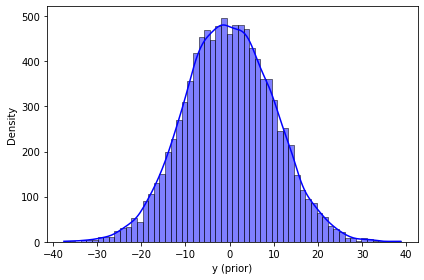

In [23]:
n_samples = 10_000
sample_mu = dist.Normal(tensor(0.), tensor(10.)).sample(torch.Size([n_samples]))
sample_sigma = dist.Exponential(tensor(1.),).sample(torch.Size([n_samples]))
prior_y = dist.Normal(sample_mu, sample_sigma).sample()
fig, ax = plt.subplots()
sns.histplot(prior_y.numpy(), color='blue', kde=True, ax=ax)
ax.set_xlabel('y (prior)')
ax.set_ylabel('Density')
fig.tight_layout()

<AxesSubplot:ylabel='Count'>

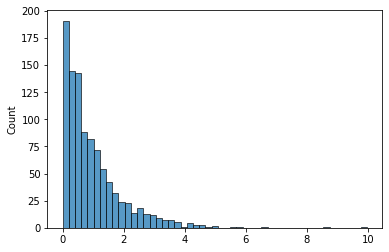

In [21]:
sns.histplot(sample_sigma)

# 4M2

In [265]:
# pyro model definition
pyro.clear_param_store()
def model_4m3(data=None, N=None):
    mu = pyro.sample('mu', dist.Normal(tensor(0.), tensor(10.)))
    sigma = pyro.sample('sigma', dist.Exponential(tensor(1.),))
    if N is None:
        N = 1 if data is None else len(data)
    with pyro.plate('data', N):
        y = pyro.sample('y', dist.Normal(mu, sigma), obs=data)
        return y

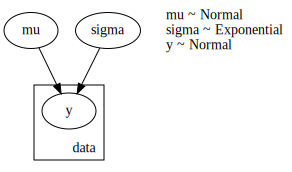

In [266]:
pyro.render_model(model_4m3, render_distributions=True, render_params=True)

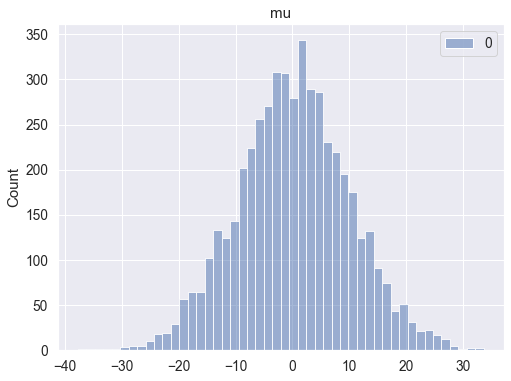

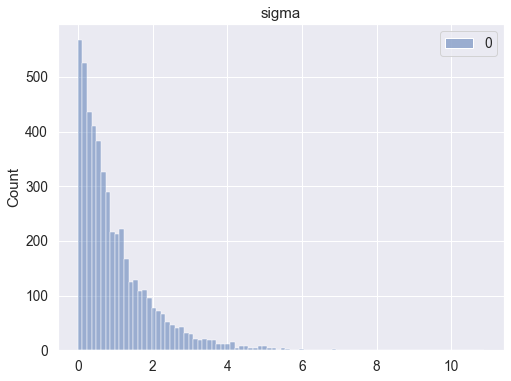

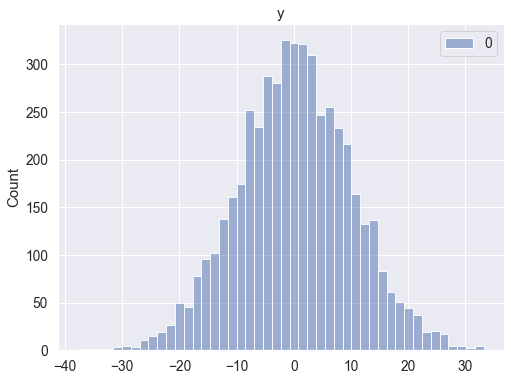

In [258]:
# prior predictive distribution
from pyro.infer import Predictive

x = model_4m3
prior_predictive = Predictive(model_4m3, {}, num_samples=5000)()
for site, values in prior_predictive.items():
    ax = sns.histplot(values)
    ax.set_title(site)
    plt.show()

# 4M3

mathematical model definition

$
y_i \sim \text{Normal}(\mu, \sigma)\newline
\mu_i = a + b*x_i\newline
a \sim \text{Normal}(0, 10)\newline
b \sim \text{Uniform}(0, 1)\newline
\sigma \sim \text{Exponential}(1)\newline
$

# 4M4

$
height_i \sim \text{Normal}(\mu, \sigma)\newline
\mu_i = a + b*year_i\newline
a \sim \text{Normal}(160, 50)\newline
b \sim \text{Normal}(10, 5)\newline
\sigma \sim \text{Exponential}(1)\newline
$

In [47]:
dist.Uniform(1990, 2000).sample(torch.Size([5])).int()

tensor([1992, 1990, 1997, 1994, 1990], dtype=torch.int32)

<AxesSubplot:ylabel='Count'>

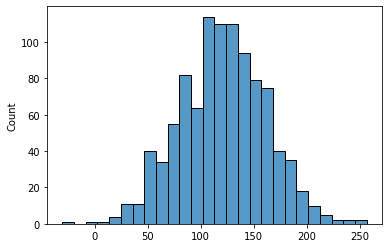

In [65]:
# intercept prior
a = dist.Normal(tensor(120.), tensor(40.)).sample(torch.Size([1000]))
sns.histplot(a)

<AxesSubplot:ylabel='Count'>

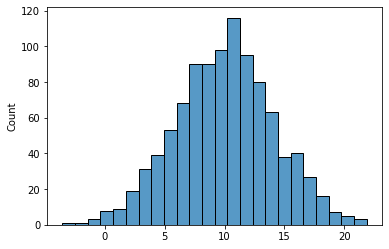

In [67]:
# slope prior
b = dist.Normal(tensor(10.), tensor(4.)).sample(torch.Size([1000]))
sns.histplot(b)

<AxesSubplot:ylabel='Count'>

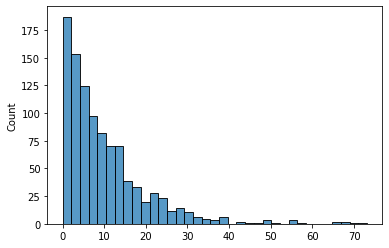

In [113]:
# slope prior
sigma = dist.Exponential(tensor(0.1)).sample(torch.Size([1000]))
sns.histplot(sigma)

In [123]:
def model_4m4(year=None, height=None, N=None):
    
    if year is not None:
        assert height is not None
        assert len(year)==len(height)
        assert isinstance(year, int)
        
    a = pyro.sample('a', dist.Normal(tensor(120.), tensor(40.)))
    b = pyro.sample('b', dist.Normal(tensor(10.), tensor(4.)))
    sigma = pyro.sample('sigma', dist.Exponential(tensor(.1),))
    
    if N is None:
        N = 1 if year is None else len(year)
        
    with pyro.plate('data_loop', N):
        year = pyro.sample('year', dist.Uniform(0, 10), obs=year).int()
#         print(year)
        mu = a + b * year
#         print(mu)
        height = pyro.sample('height', dist.Normal(mu, sigma), obs=height)
#         print(height)
        return year, height

In [124]:
# generate samples
pyro.clear_param_store()
year_samples, height_samples = model_4m4(N=2000)
print(f"{year_samples[:10]=}")
print(f"{height_samples[:10]=}")

year_samples[:10]=tensor([8, 8, 5, 9, 6, 2, 5, 5, 6, 0], dtype=torch.int32)
height_samples[:10]=tensor([283.0759, 298.9780, 224.5552, 300.6707, 249.4370, 175.2711, 235.8163,
        226.0534, 253.9278, 146.9803])


<AxesSubplot:>

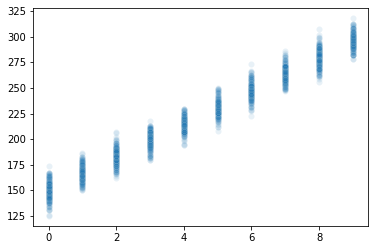

In [127]:
sns.scatterplot(x=year_samples, y=height_samples, alpha=0.1)

# 4M5

See prior above. Slope could be constrained to positive values. Could use half-Cauchy or half-Normal prior. 

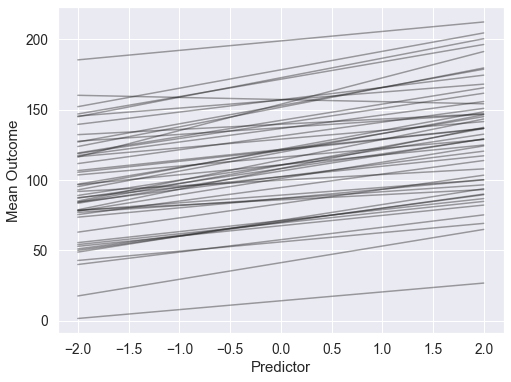

In [269]:
import numpy as np

# check that slope is positive
prior_predictive = Predictive(model_4m4, {}, num_samples=50)() 

def plot_predictive(prior_predictive):
    _, ax = plt.subplots()

    x = np.linspace(-2, 2, 50)

    for a, b in zip(prior_predictive["a"], prior_predictive["b"]):
        y = a + b * x
        ax.plot(x, y, c="k", alpha=0.4)

    ax.set_xlabel("Predictor")
    ax.set_ylabel("Mean Outcome")
    
plot_predictive(prior_predictive)

# 4M6

Sigma priors should be constrained to values uner sqrt(64) = 8.

<AxesSubplot:ylabel='Count'>

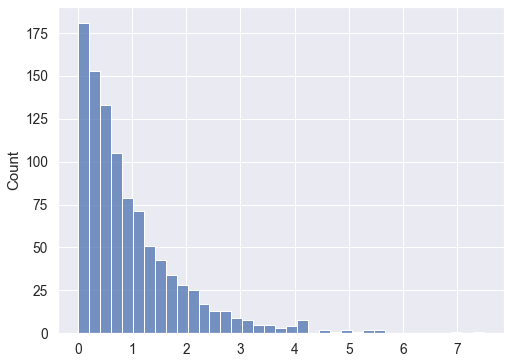

In [276]:
# check that this is already true
sns.histplot(dist.Exponential(1).sample(torch.Size([int(1e3)])))

# 4M7

In [3]:
import pandas as pd

d = pd.read_csv("../data/Howell1.csv", sep=";")
d = d[d["age"] >= 18]

<AxesSubplot:ylabel='Frequency'>

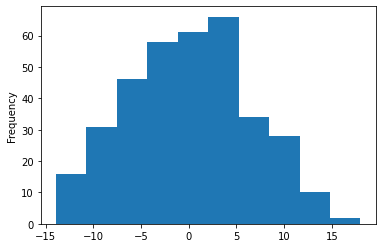

In [4]:
d['weight_c'] = d.weight - d.weight.mean()
d.weight_c.plot(kind='hist')

In [7]:
# First, calculate xbar
df = d[['height', 'weight', 'weight_c']]
train = torch.tensor(df.values, dtype=torch.float)
height, weight, weight_c = train[:, 0], train[:, 1], train[:, 2]

[Text(0.5, 0, 'weight (centered)'), Text(0, 0.5, 'height')]

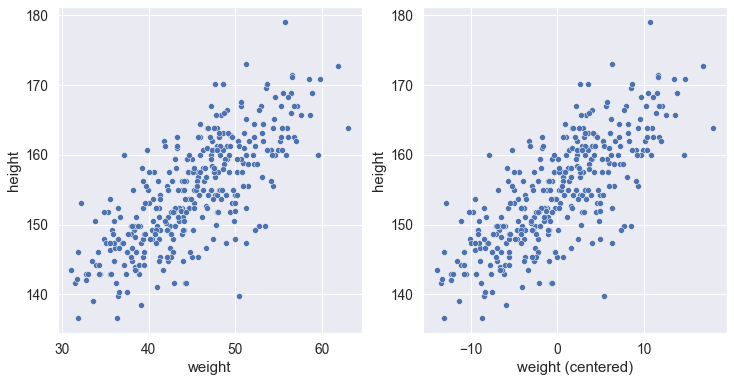

In [8]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
sns.scatterplot(x=weight, y=height, ax=ax[0])
ax[0].set(xlabel='weight', ylabel='height')
sns.scatterplot(x=weight_c, y=height, ax=ax[1])
ax[1].set(xlabel='weight (centered)', ylabel='height')

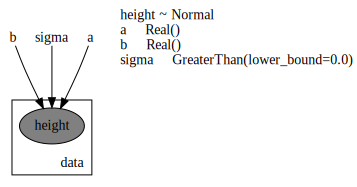

In [11]:
# MLE version

import pyro.distributions as dist
import pyro.distributions.constraints as constraints

def model(weight=None, height=None):
    a = pyro.param("a", dist.Normal(160, 20))
    b = pyro.param("b", dist.Normal(0, 10))
    sigma = pyro.param("sigma", dist.Uniform(0, 50), constraint=constraints.positive)
    
    mu = a + b * weight
    
    with pyro.plate('data'):
        return pyro.sample("height", dist.Normal(mu, sigma), obs=height)
    
pyro.render_model(model, model_args=(weight, height), render_distributions=True, render_params=True)

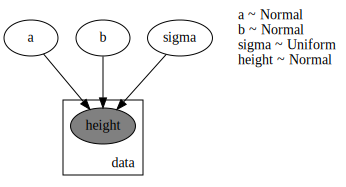

In [30]:
# Bayesian version

import pyro.distributions as dist
import pyro.distributions.constraints as constraints

def model(weight=None, height=None):
    a = 150 + pyro.sample("a", dist.Normal(10, 20))
    b = pyro.sample("b", dist.Normal(0, 10))
    sigma = pyro.sample("sigma", dist.Uniform(0, 10))
    
    mu = a + b * weight
    
    with pyro.plate('data'):
        return pyro.sample("height", dist.Normal(mu, sigma), obs=height)
    
pyro.render_model(model, model_args=(weight_c, height), render_distributions=True, render_params=True)

Elbo loss: 1533.125622868538
Elbo loss: 1137.6116515398026
Elbo loss: 1101.111444592476
Elbo loss: 1085.231633901596
Elbo loss: 1084.149559378624
Elbo loss: 1083.7040523290634
Elbo loss: 1083.7156357765198
Elbo loss: 1083.9382654428482
Elbo loss: 1084.7413446903229
Elbo loss: 1083.8030226826668
CPU times: user 3.08 s, sys: 16.1 ms, total: 3.1 s
Wall time: 3.1 s


Text(0, 0.5, 'ELBO loss')

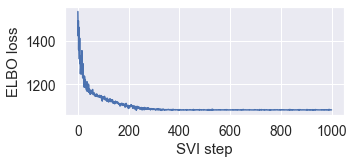

In [31]:
%%time
# mean-field variational approximation
# models distribution of unobserved parameters as a gaussian with diagonal covariance
# assumes there is non correlation between latent variables

pyro.clear_param_store()

# These should be reset each training loop.
auto_guide = pyro.infer.autoguide.AutoNormal(model)
adam = pyro.optim.Adam({"lr": 0.02})  # Consider decreasing learning rate.
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

losses = []
for step in range(1000):  # Consider running for more steps.
    loss = svi.step(weight_c, height)
    losses.append(loss)
    if step % 100 == 0:
        print("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

Sometimes models and guides are sensitive to learning rate, and the first thing to try is decreasing learning rate and increasing number of steps.

In [32]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

AutoNormal.locs.a 4.5961485
AutoNormal.scales.a 0.2583933
AutoNormal.locs.b 0.88836133
AutoNormal.scales.b 0.03831845
AutoNormal.locs.sigma 0.043059543
AutoNormal.scales.sigma 0.071573205


In [33]:
with pyro.plate("samples", 800, dim=-1):
    samples = auto_guide(weight_c, height)
    
b_learned = samples['b']

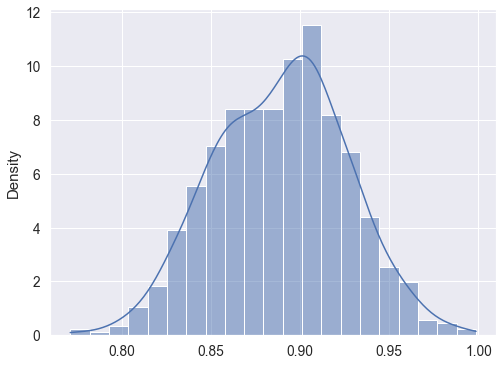

In [34]:
ax = sns.histplot(b_learned.detach().cpu().numpy(), kde=True, stat="density")

In [35]:
predictive = pyro.infer.Predictive(model, guide=auto_guide, num_samples=800)
svi_samples = predictive(weight_c, height=None)
svi_height = svi_samples["height"]

In [36]:
print(svi_height.shape)
svi_height

torch.Size([800, 352])


tensor([[154.9995, 148.2934, 142.4736,  ..., 157.1788, 158.2638, 163.7766],
        [160.3724, 144.9066, 148.3562,  ..., 159.8856, 160.8909, 169.9845],
        [146.4104, 140.0282, 144.0070,  ..., 165.1637, 152.4737, 162.6778],
        ...,
        [154.6078, 143.9119, 143.0476,  ..., 160.9360, 160.4083, 160.2390],
        [158.3152, 146.2758, 149.2817,  ..., 156.5854, 151.7959, 167.5996],
        [157.3402, 137.9806, 133.3857,  ..., 168.8599, 163.2532, 160.6653]])

[Text(0.5, 0, 'weight (centered)'), Text(0, 0.5, 'height')]

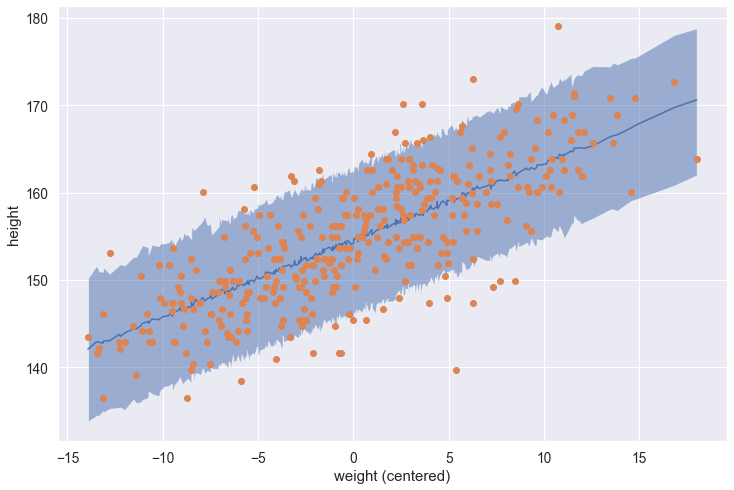

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

predictions = pd.DataFrame({
    'weight': weight_c,
    "h_mean": svi_height.mean(0).detach().cpu().numpy(),
    "h_perc_5": svi_height.kthvalue(int(len(svi_height) * 0.05), dim=0)[0].detach().cpu().numpy(),
    "h_perc_95": svi_height.kthvalue(int(len(svi_height) * 0.95), dim=0)[0].detach().cpu().numpy(),
    'true_height': height,
}).sort_values(by='weight')

f, ax = plt.subplots(figsize=(12,8))

ax.plot(predictions['weight'], predictions['h_mean'])
ax.fill_between(predictions['weight'], predictions['h_perc_5'], predictions['h_perc_95'], alpha=0.5)

ax.plot(predictions['weight'], predictions['true_height'], "o")
ax.set(xlabel='weight (centered)', ylabel='height')

Not sure how to get the covariance matrix - maybe this? https://forum.pyro.ai/t/best-practice-for-variational-inference-of-covariance-matrices/3011

# 4M8
Code example for splines not available. Probably need to implement from scratch. 
https://docs.pyro.ai/en/stable/_modules/pyro/distributions/transforms/spline.html

# 4H1

In [199]:
weights = torch.tensor([46.95, 43.72, 64.78, 32.59, 54.63])
pred_heights = sim(m4_3, data={'weight': weights})

In [200]:
pred_heights.shape

torch.Size([1000, 5])

In [203]:
height_mean = pred_heights.mean(0)
height_mean

tensor([247.8079, 244.6785, 262.1838, 233.8176, 253.1528])

In [201]:
height_PI = stats.pi(pred_heights, prob=0.89, dim=0)

In [202]:
height_PI

tensor([[186.0733, 181.8310, 201.0557, 174.0015, 192.1495],
        [305.6400, 310.0035, 324.4444, 291.4416, 312.2299]])

# 4H2

Elbo loss: 3476.520446062088
Elbo loss: 2178.5389268398285
Elbo loss: 1885.4001710414886
Elbo loss: 1826.4982670545578
Elbo loss: 1754.882509469986
Elbo loss: 1758.5815780162811
Elbo loss: 1738.093738436699
Elbo loss: 1727.9833830595016
Elbo loss: 1733.94902074337
Elbo loss: 1712.593374490738


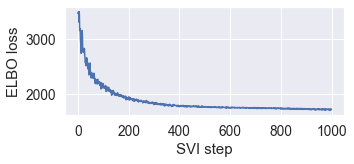

In [47]:
howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = howell1[howell1['age'] < 18]
train = torch.tensor(d[['weight', 'height']].values, dtype=torch.float)
weight, height = train[:, 0], train[:, 1]

def model(weight=None, height=None):
    a = pyro.sample("a", dist.Normal(10, 10))
    b = pyro.sample("b", dist.Normal(5, 5))
    sigma = pyro.sample("sigma", dist.Uniform(0, 50))
    with pyro.plate("plate"):
        weight = pyro.sample('weight', dist.Uniform(0, 70), obs=weight)
        height = pyro.sample("height", dist.Normal(a + b * weight, sigma), obs=height)

pyro.clear_param_store()

auto_guide = pyro.infer.autoguide.AutoNormal(model)
adam = pyro.optim.Adam({"lr": 0.02})  # Consider decreasing learning rate.
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

losses = []
for step in range(1000):  # Consider running for more steps.
    loss = svi.step(weight, height)
    losses.append(loss)
    if step % 100 == 0:
        print("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

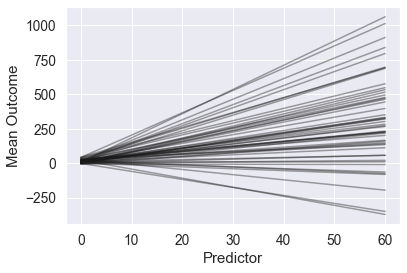

In [48]:
import numpy as np

# check that slope is positive
prior_predictive = Predictive(model, {}, num_samples=50)() 

def plot_predictive(prior_predictive, ax=None):
    if ax is None:
        _, ax = plt.subplots()

    x = np.linspace(0, 60, 60)

    for a, b in zip(prior_predictive["a"], prior_predictive["b"]):
        y = a + b * x
        ax.plot(x, y, c="k", alpha=0.4)

    ax.set_xlabel("Predictor")
    ax.set_ylabel("Mean Outcome")
    
plot_predictive(prior_predictive)

In [49]:
posterior_predictive = Predictive(model, guide=auto_guide, num_samples=10)()

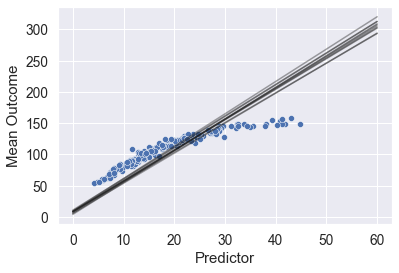

In [50]:
ax = sns.scatterplot("weight", "height", data=d)
plot_predictive(posterior_predictive, ax=ax)

In [51]:
samples = Predictive(model, guide=auto_guide, num_samples=50)(weight=weight)

In [67]:
a_samples = samples['a']
b_samples = samples['b']

map_a = a_samples.mean()
map_b = b_samples.mean()

# marginal distributions
b_05 = samples['b'].kthvalue(int(len(b_samples) * 0.05), dim=0)[0].detach().cpu().numpy()
b_95 = samples['b'].kthvalue(int(len(b_samples) * 0.95), dim=0)[0].detach().cpu().numpy()

In [66]:
plt.plot

array([4.789239], dtype=float32)

In [63]:
b_05

tensor([4.7892])

In [80]:
predictions = pd.DataFrame({
    'weight': weight,
    "h_mean": samples['height'].mean(0).detach().cpu().numpy(),
    "h_perc_5": samples['height'].kthvalue(int(len(samples['height']) * 0.05), dim=0)[0].detach().cpu().numpy(),
    "h_perc_95": samples['height'].kthvalue(int(len(samples['height']) * 0.95), dim=0)[0].detach().cpu().numpy(),
    'true_height': height,
}).sort_values(by='weight')

In [81]:
predictions

,weight,h_mean,h_perc_5,h_perc_95,true_height
177,4.252425,28.866640,-24.314138,69.908615,53.974998
156,4.847764,34.440033,-10.157146,74.462250,55.880001
178,5.159609,28.116243,-17.424004,74.701294,56.514999
102,5.669900,37.283222,-40.683456,83.557182,60.452000
86,5.896696,40.029163,-15.266525,89.453087,59.613800
...,...,...,...,...,...
79,41.276871,208.056824,148.127335,246.400436,147.955002
155,41.305222,207.857681,155.738647,256.290100,157.479996
19,41.900562,216.682617,150.649551,261.601044,147.955002
67,43.091240,226.803177,177.449905,276.996063,158.115005


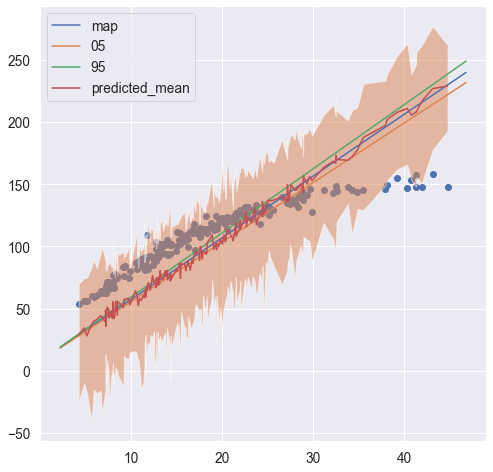

In [88]:
f, ax = plt.subplots(figsize=(8,8),)

ax.scatter(weight, height)

xlim = ax.get_xlim()
x = np.linspace(*xlim, 10)
y = map_a + map_b * x
y_05 = map_a + b_05 * x
y_95 = map_a + b_95 * x
ax.plot(x, y, label='map')
ax.plot(x, y_05, label='05')
ax.plot(x, y_95, label='95')

ax.plot(predictions['weight'], predictions['h_mean'], label='predicted_mean')
ax.fill_between(predictions['weight'], predictions['h_perc_5'], predictions['h_perc_95'], alpha=0.5)

# ax.set(xlabel='weight (centered)', ylabel='height')

ax.legend()

# ax.fill_between(weight, predictions['h_perc_5'], predictions['h_perc_95'], alpha=0.5)

# ax.plot(predictions['weight'], predictions['true_height'], "o")
# ax.set(xlabel='weight (centered)', ylabel='height')

# 4H3

Elbo loss: 13254.326183915138
Elbo loss: 7869.023512244225
Elbo loss: 7299.094079852104
Elbo loss: 6933.663694381714
Elbo loss: 6737.699545145035
Elbo loss: 6444.030441522598
Elbo loss: 6326.924156308174
Elbo loss: 6172.650512933731
Elbo loss: 6019.66813492775
Elbo loss: 5895.037545263767


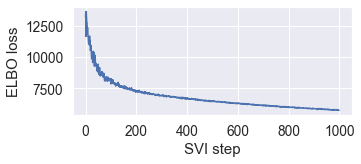

In [105]:
d = pd.read_csv("../data/Howell1.csv", sep=";")
d['log_weight'] = np.log(d.weight)
train = torch.tensor(d[['log_weight', 'height']].values, dtype=torch.float)
weight, height = train[:, 0], train[:, 1]

def model(weight=None, height=None):
    a = pyro.sample("a", dist.Normal(50, 10))
    b = pyro.sample("b", dist.Normal(60, 5))
    sigma = pyro.sample("sigma", dist.Uniform(0, 50))
    with pyro.plate("plate"):
        weight = pyro.sample('weight', dist.Uniform(0, 70), obs=weight)
        height = pyro.sample("height", dist.Normal(a + b * weight, sigma), obs=height)

pyro.clear_param_store()

auto_guide = pyro.infer.autoguide.AutoNormal(model)
adam = pyro.optim.Adam({"lr": 0.02})  # Consider decreasing learning rate.
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

losses = []
for step in range(1000):  # Consider running for more steps.
    loss = svi.step(weight, height)
    losses.append(loss)
    if step % 100 == 0:
        print("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [106]:
samples = Predictive(model, guide=auto_guide, num_samples=50)(weight=weight)

In [107]:
predictions = pd.DataFrame({
    'weight': weight,
    "h_mean": samples['height'].mean(0).detach().cpu().numpy(),
    "h_perc_5": samples['height'].kthvalue(int(len(samples['height']) * 0.05), dim=0)[0].detach().cpu().numpy(),
    "h_perc_95": samples['height'].kthvalue(int(len(samples['height']) * 0.95), dim=0)[0].detach().cpu().numpy(),
    'true_height': height,
}).sort_values(by='weight')

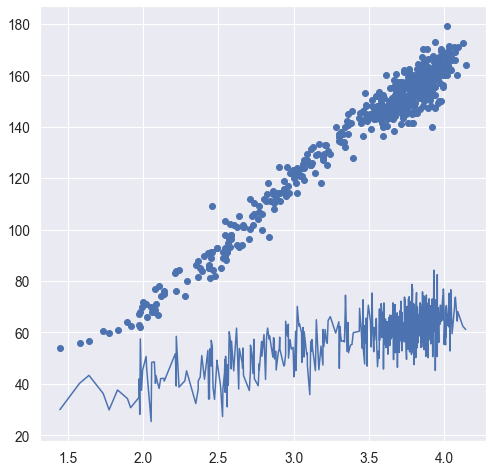

In [108]:
f, ax = plt.subplots(figsize=(8,8),)

ax.scatter(d.log_weight, height)

ax.plot(predictions['weight'], predictions['h_mean'], label='predicted_mean')
# ax.fill_between(predictions['weight'], predictions['h_perc_5'], predictions['h_perc_95'], alpha=0.5)
